In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

### MBP-10 is a Level 2 (L2) order book data feed that includes only the best 10 bid and ask prices, their sizes, and order counts. This is a standard practice because: 

- Most trades occur near the top of the book (best bid/ask prices).

- Data beyond 10 levels is often not critical for short-term trading strategies and would create large data overhead.

In [3]:
base_path = r".\Quantitative Research Intern data"

tickers = ["CRWV", "FROG", "SOUN"]

# Dictionary to store DataFrames for each ticker
data = {}

for ticker in tickers:
    folder_path = os.path.join(base_path, ticker)
    csv_files = glob.glob(os.path.join(folder_path, f"{ticker}_2025-04-03*.csv"))
    
    # Load and concatenate all CSVs for the current ticker
    df_list = [pd.read_csv(file) for file in csv_files]
    data[ticker] = pd.concat(df_list, ignore_index=True)
    
    print(f"Loaded {len(csv_files)} files for {ticker}, total rows: {len(data[ticker])}")


data["CRWV"].head(10)

Loaded 1 files for CRWV, total rows: 189869
Loaded 1 files for FROG, total rows: 33286
Loaded 1 files for SOUN, total rows: 362850


,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,B,0,55.40,99,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
1,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,B,0,55.40,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
2,2025-04-03 13:30:00.012155347+00:00,2025-04-03 13:30:00.012155347+00:00,10,2,20613,T,N,0,55.40,551,...,10,1,1,54.55,56.91,100,100,1,1,CRWV
3,2025-04-03 13:30:00.012344442+00:00,2025-04-03 13:30:00.012344442+00:00,10,2,20613,A,A,0,55.40,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
4,2025-04-03 13:30:00.012800457+00:00,2025-04-03 13:30:00.012800457+00:00,10,2,20613,A,B,0,55.39,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
5,2025-04-03 13:30:00.013396841+00:00,2025-04-03 13:30:00.013396841+00:00,10,2,20613,C,B,0,53.68,100,...,4,1,1,54.55,56.70,100,10,1,1,CRWV
6,2025-04-03 13:30:00.120353811+00:00,2025-04-03 13:30:00.120353811+00:00,10,2,20613,A,B,0,55.28,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
7,2025-04-03 13:30:00.121870648+00:00,2025-04-03 13:30:00.121870648+00:00,10,2,20613,T,B,0,55.40,100,...,4,1,1,54.57,56.70,400,10,1,1,CRWV
8,2025-04-03 13:30:00.121870648+00:00,2025-04-03 13:30:00.121870648+00:00,10,2,20613,C,A,0,55.40,100,...,10,1,1,54.57,56.83,400,100,1,1,CRWV
9,2025-04-03 13:30:00.121873007+00:00,2025-04-03 13:30:00.121873007+00:00,10,2,20613,T,N,0,55.40,100,...,10,1,1,54.57,56.83,400,100,1,1,CRWV


## **Modeling the Temporary Impact $g_t(x)$**

### **Introduction**

The temporary impact $g_t(x)$ measures the additional cost (or slippage) incurred when executing a trade of size $x$ at time $t$. It represents how aggressively consuming liquidity from the order book affects the average execution price relative to the mid-price (average of best bid and best ask). An accurate model for $g_t(x)$ is crucial for minimizing execution costs, especially when handling large orders that can move the market.

---

### **So, why not a Linear Model??**

A common approximation is:

$$
g_t(x) \approx \beta_t x,
$$

where $\beta_t$ is the cost per share at time $t$.
While this model is simple and easy to work with, it **assumes slippage grows at a constant rate per share**, which is rarely true. In reality, the order book is structured in **layers (price levels)** with varying quantities of shares. For small $x$, slippage may appear linear, but as $x$ grows and trades “eat through” multiple price levels, the cost rises faster. This creates a **nonlinear shape** that a linear model fails to capture.

For example, consider the order book snapshot:

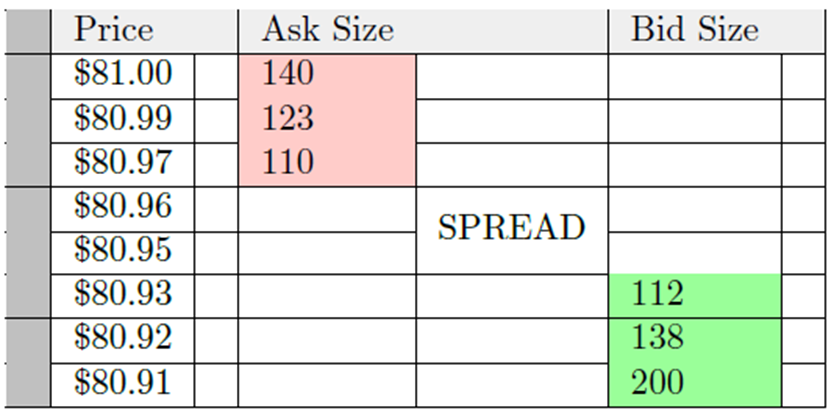

If you buy 50 shares, you get them all at \$80.97. If you buy 200 shares, you take 110 shares at \$80.97 and 90 shares at \$80.99, meaning the cost per share **increases nonlinearly** with trade size.

---

### **Why a Nonlinear Model?**

To capture this, I propose modeling $g_t(x)$ using a **piecewise quadratic function** or a **power-law form**, both of which are widely used in market microstructure research:

#### **The Quadratic Model:**

$$
g_t(x) = c + a_t x + b_t x^2,
$$

* The $a_t x$ term accounts for the baseline cost (close to linear for small x).
* The $b_t x^2$ term captures how cost accelerates as we consume multiple price levels.
* The $c$ is the y-intercept or the baseline slippage.

This is a **convex function**, meaning slippage grows faster as order size increases, which matches real-world behavior.

---

### **Estimating $g_t(x)$ from Data**

To estimate $g_t(x)$ using the 3 provided tickers:

1. **Construct the Order Book Depth:**
   For each time $t$, we list the available quantities at each ask price.
2. **Simulate Market Orders of Size x:**
   For a hypothetical buy of $x$ shares, we compute the **volume-weighted average price (VWAP)**:

   $$
   P_{\text{avg}}(x) = \frac{\sum_{j} P_j Q_j}{x},
   $$

   where $P_j$ and $Q_j$ are the price and quantity at level $j$ of the order book until $x$ shares are filled.
3. **Compute Slippage:**

   $$
   g_t(x) = P_{\text{avg}}(x) - P_{\text{mid}}(t),
   $$

   where $P_{\text{mid}}(t)$ is the mid-price.
4. **Fit the Model:**
   Using (x, g\_t(x)) data points for different trade sizes, we fit a curve $g_t(x) = c + a_t x + b_t x^2$.


The reason I added the **y-intercept** is:
1. Real-world slippage data rarely passes through (0,0).
   
2. Forcing the curve through zero (no intercept) can distort `a` and `b`.
  
3. Adding `c` gives the model flexibility:** The constant term absorbs the baseline bias , so the quadratic terms (a and b) focus only on modeling the growth of slippage with order size.

In [4]:
# Creating an Order Book snapshot
def get_order_book_snapshot_for_tickers(data_dict, index=0):

    snapshots = {}
    for ticker, df in data_dict.items():
        row = df.iloc[index]
        ask_prices = [row[f'ask_px_{i:02}'] for i in range(10)]
        bid_prices = [row[f'bid_px_{i:02}'] for i in range(10)]
        ask_sizes = [row[f'ask_sz_{i:02}'] for i in range(10)]
        bid_sizes = [row[f'bid_sz_{i:02}'] for i in range(10)]
        
        snapshots[ticker] = pd.DataFrame({
            'ask_px': ask_prices,
            'ask_sz': ask_sizes,
            'bid_px': bid_prices,
            'bid_sz': bid_sizes
        })
    return snapshots

# Example usage:
order_books = get_order_book_snapshot_for_tickers(data, index=0)

for ticker, _ in data.items():
    print(f"Order Book for {ticker}:")
    print(order_books[ticker])
    print()



Order Book for CRWV:
   ask_px  ask_sz  bid_px  bid_sz
0   55.40     199   55.10       1
1   55.46      10   55.06    1667
2   55.47     100   55.03     200
3   55.50     100   55.00      80
4   55.93      50   54.98      20
5   56.00     200   54.80      10
6   56.24       3   54.78     100
7   56.45       5   54.66       1
8   56.66       4   54.57     400
9   56.70      10   54.55     100

Order Book for FROG:
   ask_px  ask_sz  bid_px  bid_sz
0   32.00     200   30.10      50
1   32.64     100   30.00     147
2   32.66     200   29.99       1
3   32.82     800   29.76     200
4   33.15      10   29.23     800
5   33.18       5   29.10     100
6   33.28     200   29.00      20
7   33.30     800   28.97     100
8   33.85       4   28.96     800
9   33.92     100   28.49     100

Order Book for SOUN:
   ask_px  ask_sz  bid_px  bid_sz
0    7.91     164    7.89     112
1    7.92       4    7.88     132
2    7.94      30    7.87     168
3    7.95      79    7.86     651
4    7.99      29

### Function to calculate the price impact of a trade or slippage

In [ ]:
#Calculate temporary impact (slippage) for buying x shares from ask side.
def calculate_slippage(order_book, x):
    """
    Calculate temporary impact (slippage) for buying x shares from ask side.
    """
    ask_prices = order_book['ask_px'].values
    ask_sizes = order_book['ask_sz'].values

    shares_remaining = x
    cost = 0
    for price, size in zip(ask_prices, ask_sizes):
        shares_to_buy = min(size, shares_remaining)
        cost += shares_to_buy * price
        shares_remaining -= shares_to_buy
        if shares_remaining <= 0:
            break

    if shares_remaining > 0:
        # Not enough liquidity in the book to buy x shares
        cost += shares_remaining * ask_prices[-1]  # assume last level price

    avg_price = cost / x # calculate the volume-weighted average price of the shares bought
    mid_price = (order_book['ask_px'].iloc[0] + order_book['bid_px'].iloc[0]) / 2 #calculating the mid price
    slippage = avg_price - mid_price
    return slippage


### Simulating the Slippage

In [13]:
# Simulating the slippage 
def simulate_all_tickers(order_books, max_x=30000, step=500):
    results = {}
    for ticker, df in order_books.items():
        x_values = list(range(step, max_x + step, step))
        g_values = [calculate_slippage(df, x) for x in x_values]
        results[ticker] = (x_values, g_values)
    return results

### Fitting and plotting the result of the simulation of the quadratic model.

Fitted Model for CRWV: g_t(x) = 0.9531 + 0.0001x + -0.000000x²
Fitted Model for FROG: g_t(x) = 1.7743 + 0.0001x + -0.000000x²
Fitted Model for SOUN: g_t(x) = 0.1107 + 0.0000x + -0.000000x²


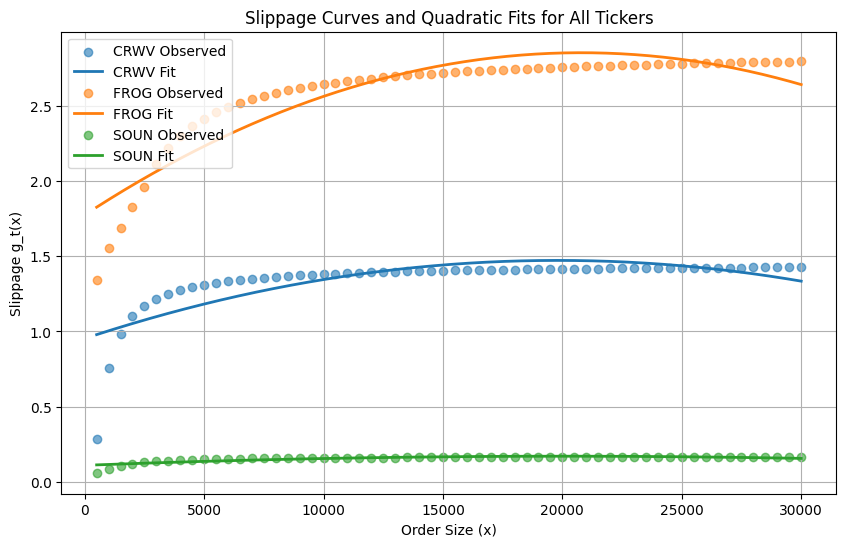

In [14]:
# Fitting the Quadratic Model to Simulated Slippage Curves
def fit_quadratic(x_values, g_values):
    x = np.array(x_values)
    g = np.array(g_values)

    # Create matrix with columns [1, x, x^2]
    A = np.vstack([np.ones(len(x)), x, x**2]).T
    c, a, b = np.linalg.lstsq(A, g, rcond=None)[0]
    return c, a, b

# Run simulations for all tickers
results = simulate_all_tickers(order_books)

# Plot results and fits
plt.figure(figsize=(10, 6))
for t in tickers:   
    x_values, g_values = results[t]
    c, a, b = fit_quadratic(x_values, g_values)
    print(f"Fitted Model for {t}: g_t(x) = {c:.4f} + {a:.4f}x + {b:.6f}x²")
    
    # Generate fitted curve
    x_fit = np.linspace(min(x_values), max(x_values), 200)
    g_fit = c + a * x_fit + b * x_fit**2
        
    # Plot observed vs fitted
    plt.scatter(x_values, g_values, label=f"{t} Observed", alpha=0.6)
    plt.plot(x_fit, g_fit, linewidth=2, label=f"{t} Fit")

plt.title("Slippage Curves and Quadratic Fits for All Tickers")
plt.xlabel("Order Size (x)")
plt.ylabel("Slippage g_t(x)")
plt.grid(True)
plt.legend()
plt.show()